# Image Captioning using ViT and GPT-2
The second part of the pipeline consists of taking the extracted images as input and transforming them to a human-understandable text. This problem is more commonly known as image captioning, and many pre-existing models exist. One of the most commonly used technique for image captioning is by using an image encoding to transform the image into an embedding which can then be used as input for a language model. This language model then decodes the embedding back into natural language. A commonly used combination is the ViT/GPT-2 pair.

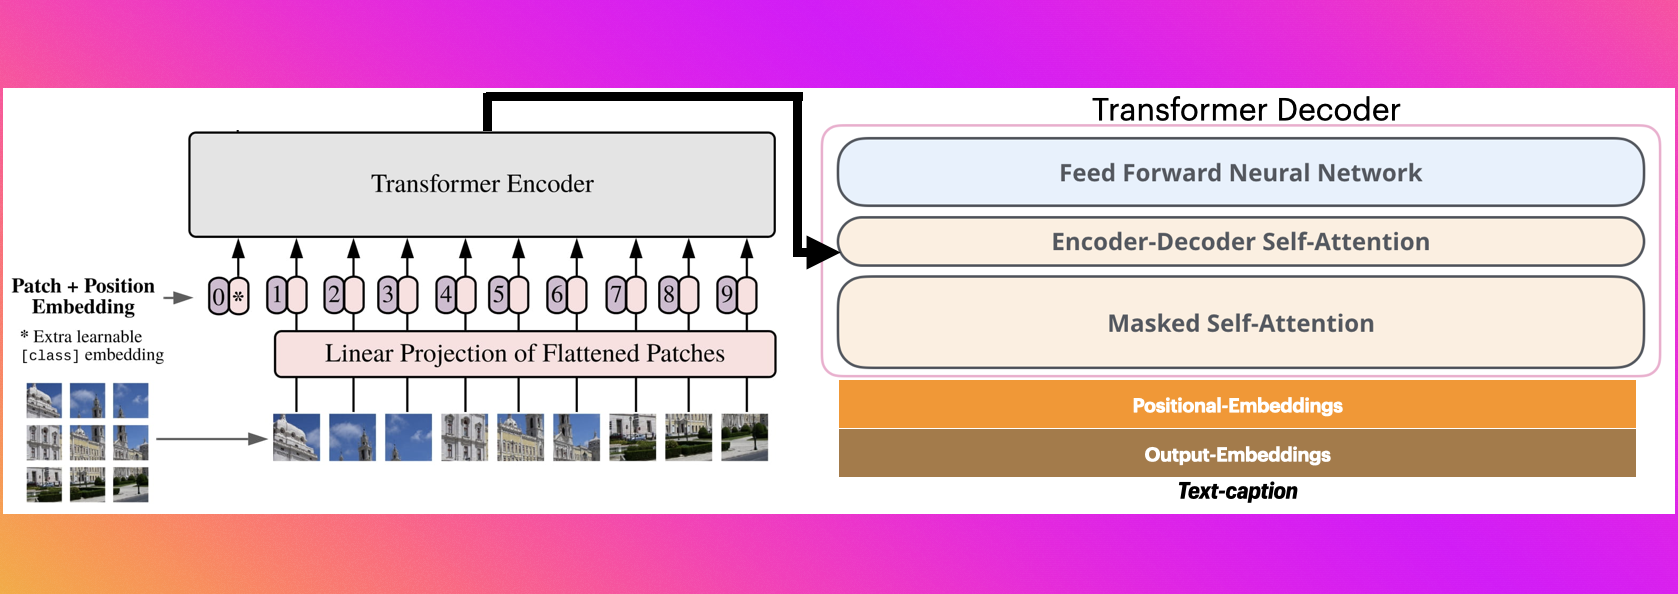

### Sources
The sources used in this notebook include:

    - https://huggingface.co/nlpconnect/vit-gpt2-image-captioning
    - https://huggingface.co/docs/transformers/model_doc/vit
    - https://huggingface.co/docs/transformers/model_doc/gpt2
    - https://github.com/NjtechCVLab/RSTPReid-Dataset
    - https://vision.cornell.edu/se3/wp-content/uploads/2018/03/1501.pdf
    - https://en.wikipedia.org/wiki/BLEU
    - https://en.wikipedia.org/wiki/METEOR
    - https://huggingface.co/spaces/evaluate-metric/rouge
    - The courses in the postgraduate "AI and ML in business and engineering" at KULeuven.

In [1]:
%env TF_ENABLE_ONEDNN_OPTS=0

# Imports
from pathlib import Path
import torch
import ipyplot
from matplotlib import pyplot as plt
from datetime import datetime
from torch.utils import tensorboard
from transformers import GPT2TokenizerFast, ViTImageProcessor, VisionEncoderDecoderModel
from transformers import logging
logging.set_verbosity_error()

from libs.dataset import RSTPReid
from libs.evaluation import evaluate_model, predict
from libs.training import train_one_epoch

env: TF_ENABLE_ONEDNN_OPTS=0


2023-05-13 09:35:34.773784: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-13 09:35:35.977311: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /apps/leuven/icelake/2021a/software/CUDA/11.7.1/nvvm/lib64:/apps/leuven/icelake/2021a/software/CUDA/11.7.1/extras/CUPTI/lib64:/apps/leuven/icelake/2021a/software/CUDA/11.7.1/lib64
2023-05-13 09:35:35.977381: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot

In [2]:
# Define constants
MODEL_NAME = "nlpconnect/vit-gpt2-image-captioning"
DATASET_PATH = Path().resolve().parent / 'RSTPReid'

## Load the model
ViT (Vision Transformer) is a Transformer encoder, which was trained on ImageNet. It attained "excellent results compared to state-of-the-art convolutional networks while requiring substantially fewer computational resources to train", according the the original paper by Dosovitskiy, Beyer, Kolesnikov, Weissenborn, Zhai, Unterthiner, Dehghani, Minderer, Heigold, Gelly, Uszkoreit, and Houlsby.

GPT-2 is a large transformer-based language model with 1.5 billion parameters, trained on a dataset of 8 million web pages. It is trained with a simple objective: predict the next word, given all of the previous words within a text.

In [3]:
%%capture
# Load the models
model = VisionEncoderDecoderModel.from_pretrained(MODEL_NAME)
image_processor = ViTImageProcessor.from_pretrained(MODEL_NAME)
tokenizer = GPT2TokenizerFast.from_pretrained(MODEL_NAME)
# Place the model on the correct device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

In [4]:
# GPT2 only has bos/eos tokens but not decoder_start/pad tokens
tokenizer.pad_token = tokenizer.eos_token

# update the model config
model.config.eos_token_id = tokenizer.eos_token_id
model.config.decoder_start_token_id = tokenizer.bos_token_id
model.config.pad_token_id = tokenizer.pad_token_id

## Load the data
Since the goal is to keep the Televic-provided images as testset, a publicly available data set is required to validate the performance of the model, and finetune it if necessary. The dataset used in this notebook is the RSTPReid (Real Scenario Textbased Person Re-identification) dataset.  
This dataset consists of 20505 images of 4101 persons from 15 cameras. Each person has 5 corresponding images taken by different cameras with complex scene transformations and backgrounds. Each image is annotated with 2 textual descriptions. The dataset comes pre-split into train-, validation-, and testsets, according to a 90-5-5 split.

In [5]:
# Load the datasets
train_set = RSTPReid(DATASET_PATH, 'train', image_processor)
val_set = RSTPReid(DATASET_PATH, 'val', image_processor)
test_set = RSTPReid(DATASET_PATH, 'test', image_processor)

print(f"Number of elements in the training set: {len(train_set)}")
print(f"Number of elements in the validation set: {len(val_set)}")
print(f"Number of elements in the test set: {len(test_set)}")

Number of elements in the training set: 18505
Number of elements in the validation set: 1000
Number of elements in the test set: 1000


In [6]:
examples = [val_set.get_example(0), val_set.get_example(10), val_set.get_example(20)]
ipyplot.plot_images([str(x['image_path']) for x in examples], show_url=False)
for i, x in enumerate(examples):
    print(f"{i}) {x['caption']}\n")

0) The girl with long black hair is wearing a light pink down coat a piar of leggings and looking forward.

1) The man with a pair of glasses behind someone is wearing a dark coat and he is looking in a certain direction

2) A man in a plaid sweater was walking on the road. He was about to open the glass door. He was wearing gray trousers



An initial sample can give us an insight in the type of data contained in the data set. However, it is also interesting to see how long the captions generally are. To visualise this, we can plot the length of each example in the training set. To make the difference between lengths a little bit more clear, the length has been plotted in function of itself. Plotting the length on a horizontal line would remove no information, but makes the difference visually less clear.

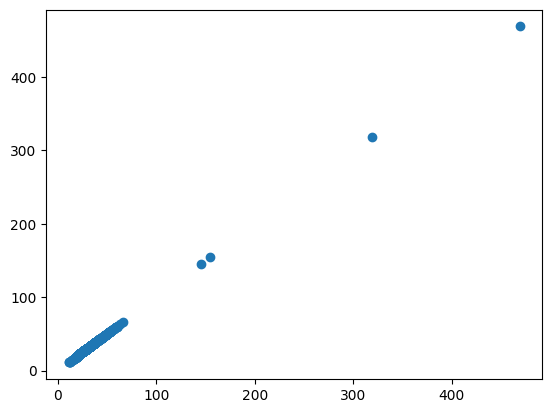

In [7]:
lengths = []
for i in range(len(train_set)):
    example = train_set.get_example(i)
    caption = example["caption"]
    split_caption = caption.replace(".", ". ").replace("  ", " ").strip().split(" ")
    lengths.append(len(split_caption))
plt.scatter(lengths, lengths)
plt.show()

This graphs shows that there 4 weird outliers in the training set. Let's see what these outliers contain: 

In [8]:
for i in range(len(train_set)):
    example = train_set.get_example(i)
    caption = example["caption"]
    split_caption = caption.replace(".", ". ").replace("  ", " ").strip().split(" ")
    if len(split_caption) > 100:
        print(f"Index {i}: {caption}")
        print("-"*160)

Index 4357: A young man, wearing black glasses, a brown coat, blue jeans, and black sneakers, was walking along the roadA young man, wearing black glasses, a brown coat, blue jeans, and black sneakers, was walking along the roadA young man, wearing black glasses, a brown coat, blue jeans, and black sneakers, was walking along the roadA young man, wearing black glasses, a brown coat, blue jeans, and black sneakers, was walking along the roadA young man, wearing black glasses, a brown coat, blue jeans, and black sneakers, was walking along the roadA young man, wearing black glasses, a brown coat, blue jeans, and black sneakers, was walking along the roadA young man, wearing black glasses, a brown coat, blue jeans, and black sneakers, was walking along the roadA young man, wearing black glasses, a brown coat, blue jeans, and black sneakers, was walking along the roadA young man, wearing black glasses, a brown coat, blue jeans, and black sneakers, was walking along the roadA young man, wea

It seems that the dataset was built automatically, and that some mistakes got introduced during this process. We should remove them from the dataset before actually retraining the models later on in this notebook.

In [9]:
train_set.remove_indices([4357, 5323, 6225, 6391])
print("The new length of the training set is:", len(train_set))

The new length of the training set is: 18501


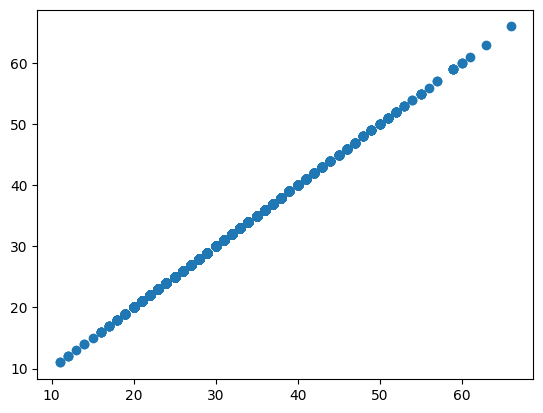

In [10]:
lengths = []
for i in range(len(train_set)):
    example = train_set.get_example(i)
    caption = example["caption"]
    split_caption = caption.replace(".", ". ").replace("  ", " ").strip().split(" ")
    lengths.append(len(split_caption))
plt.scatter(lengths, lengths)
plt.show()

The new spread of lengths is more in line with expectations. The outliers have been removed.

## Defining an evaluation metric
To evaluate how well our model performs on the previously defined dataset, an evaluation metric is required. Commonly used metrics consist of CIDEr, METEOR, ROUGE, and BLUE. It is known that these metrics don't always correlate well with human judgement, and that each metric has well known blind spots. However, they are easy to use, and are often implemented in popular machine learning libraries. Since our use case is rather simplistic, they will suffice.  

- CIDEr (Consensus-based Image Description Evaluation) is a simple metric, which was defined specifically for image classification. However, since it is very new, there are no verified implementations in common libraries.
- METEOR (Metric for Evaluation of Translation with Explicit Ordering) is a metric for the evaluation of machine translation output. Since this is not our use case, this metric might be less suitable.
- ROUGE (Recall-Oriented Understudy for Gisting Evaluation) is a set of metrics used for evaluating automatic summarization and machine translation. Since our use case can (generously) be described as summarizing an image into a short sentence, this metric might be suitable.
- BLUE (Bilingual evaluation understudy) is an algorithm for evaluating the quality of a text which has been machine translated from one natural language to another. Since the use case here is not machine translation, this metric might not be very well suited.
It should be noted that a more naive approach would be to simple use the Word Error Rate. However, this is a bad scoring way, since it does not account for synonyms.

The evaluation metrics that are used in this notebook are the ROUGE metrics. Specifically, we'll calculate the rouge1, rouge2, rougeL, and rougeLsum metric. Let's first expand on what these metrics or scores actually measure:
- rouge1: The percentage of overlapping unigrams between the reference and the prediction.
- rouge2: The percentage of overlapping bigrams between the reference and the prediction.
- rougeL: A metric based on the longest common subsequence (LCS) between the reference and the prediction.
- rougeLsum: The average rougeL score when split on newlines.

A popular way of improving the accuracy of a language model is to feed the generated output back into the model, and using beam search to optimise the output. The number of beams is something that can be tuned to the specific problem, so we'l calculate the accuracy of the model using no beam search, or when using 3, 5, or 7 beams.

In [11]:
for beams in (None, 3, 5, 7):
    if beams is None:
        model_kwargs = {"max_new_tokens": 25}
    else:
        model_kwargs = {"max_new_tokens": 25, "num_beams": beams}
    result = evaluate_model(model, val_set, tokenizer, image_processor, device, model_kwargs)
    print(f"BEAMS: {beams} => {result}")

100%|██████████| 1000/1000 [03:00<00:00,  5.55it/s]


BEAMS: None => {'rouge1': 0.26677262771807464, 'rouge2': 0.03773767787137799, 'rougeL': 0.20766258035893348, 'rougeLsum': 0.207514182736459}


100%|██████████| 1000/1000 [04:27<00:00,  3.74it/s]


BEAMS: 3 => {'rouge1': 0.2560595787649821, 'rouge2': 0.029628403030064348, 'rougeL': 0.1956596964144959, 'rougeLsum': 0.19573034203164733}


100%|██████████| 1000/1000 [05:56<00:00,  2.81it/s]


BEAMS: 5 => {'rouge1': 0.2520997717401688, 'rouge2': 0.028013311513599308, 'rougeL': 0.19206300606217672, 'rougeLsum': 0.19205933651890766}


100%|██████████| 1000/1000 [07:34<00:00,  2.20it/s]


BEAMS: 7 => {'rouge1': 0.2497208207977039, 'rouge2': 0.027337544228353036, 'rougeL': 0.19080805274615487, 'rougeLsum': 0.19080794512355295}


From these results, we can conclude that using beam search for this specific problem does not improve the output. This is to be expected, as the decoder works in a generative fashion, and iterating over the output puts less focus on the information extracted by the encoder, and more focus on underlying biases of the decoder.

In [12]:
torch.cuda.empty_cache()

This metric gives a numerical description of the accuracy of our model. However, it is still useful to take a look at a small sample of the predictions, to get a feel of what these numbers mean. These examples make it obvious that the model can perform the task, but requires some fine-tuning to get the type of captions required for the Televic use case.

In [13]:
model_kwargs = {"max_new_tokens": 25}
examples = [val_set.get_example(0), val_set.get_example(10), val_set.get_example(20)]
predictions = [predict(model, x['image_path'], tokenizer, image_processor, device, model_kwargs) for x in examples]

ipyplot.plot_images([str(x['image_path']) for x in examples], show_url=False)
for i, x in enumerate(predictions):
    print(f"{i}) {x}\n")
torch.cuda.empty_cache()

0) a woman walking down a sidewalk with a snowboard

1) a man is standing in front of a wall with a group of people

2) a man is playing a game on a cell phone



## Retraining the model
To improve the accuracy of the model, we can retrain it on the available dataset. In this notebook, we assume that the decoder (GPT-2) is accurate enough. For this reason, we'll only finetune the encoder.

In [14]:
# Freeze all parameters that are a part of the decoder (GTP-2)
for param in model.decoder.parameters():
     param.requires_grad = False
params = [p for p in model.parameters() if p.requires_grad]
print(f"We're finetuning {len(params)} of the {len(list(model.parameters()))} parameters.")

We're finetuning 200 of the 444 parameters.


In [15]:
# Convert the dataset to a dataloader
dataloader = torch.utils.data.DataLoader(
    dataset=train_set,
    batch_size=1,
    collate_fn = train_set.custom_collate
)

Furthermore, the model expects that all training examples in a single batch have the same length of captions. To make sure this is the case, we've added padding to the tokens. The code belows shows the longest sequence of tokens in the training set was 73 (and no outliers were detected!). For this reason, we'll pad all sequences up to 73 tokens.

100%|██████████| 18501/18501 [01:24<00:00, 218.40it/s]


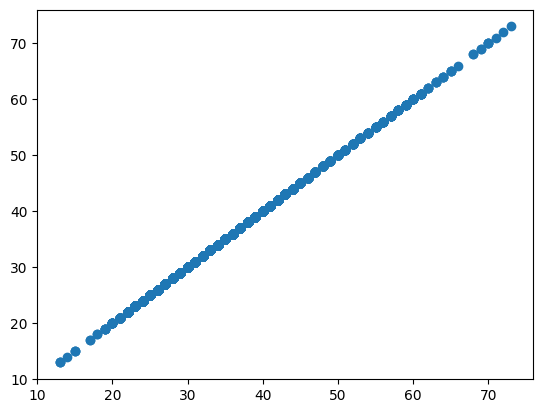

In [16]:
from tqdm import tqdm
lengths = []

for image, caption in tqdm(dataloader):
    tokens = tokenizer(caption, return_tensors="pt").input_ids
    lengths.append(tokens.shape[1])
plt.scatter(lengths, lengths)
plt.show()

In [17]:
print(max(lengths))

73


After padding, the training data looks like:

In [18]:
image, caption = next(iter(dataloader))
tokens = tokenizer(caption, return_tensors="pt", padding="max_length", max_length=73).input_ids
print(image)
print("-"*160)
print(tokens)

tensor([[[-0.0510,  0.0588,  0.0824,  ...,  0.2784,  0.1922,  0.2078],
         [ 0.0039,  0.0431, -0.0118,  ...,  0.1294,  0.1765,  0.2706],
         [-0.0588, -0.0902, -0.1451,  ...,  0.1765,  0.2549,  0.3333],
         ...,
         [-0.4588, -0.4745, -0.4667,  ..., -0.3647, -0.3882, -0.4039],
         [-0.4824, -0.4824, -0.4588,  ..., -0.4275, -0.4275, -0.4118],
         [-0.4588, -0.4824, -0.4667,  ..., -0.4039, -0.4118, -0.4118]],

        [[-0.1373, -0.0275, -0.0039,  ...,  0.1608,  0.0745,  0.0980],
         [-0.0824, -0.0431, -0.0980,  ..., -0.0118,  0.0431,  0.1294],
         [-0.1686, -0.1922, -0.2471,  ...,  0.0196,  0.0902,  0.1608],
         ...,
         [-0.4196, -0.4353, -0.4196,  ..., -0.2706, -0.2863, -0.3098],
         [-0.4118, -0.4196, -0.3961,  ..., -0.3333, -0.3333, -0.3255],
         [-0.3804, -0.4039, -0.3725,  ..., -0.3098, -0.3255, -0.3412]],

        [[-0.0745,  0.0353,  0.0588,  ...,  0.1373,  0.0510,  0.0745],
         [-0.0196,  0.0196, -0.0353,  ..., -0

In [19]:
# Convert the dataset to a dataloader
dataloader = torch.utils.data.DataLoader(
    dataset=train_set,
    batch_size=2,
    collate_fn = train_set.custom_collate
)

In [20]:
# Define an optimizer and a learning rate scheduler
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

Define a SummaryWriter, so we can log our training loss during training.

In [21]:
writername = datetime.now().strftime("%Y%m%d_%H%M%S")
writername = f"runs/{writername}"
writer = tensorboard.SummaryWriter(writername)

In [ ]:
model_save_path = Path().resolve() / 'retrained_model'
# If a trained model already exists, load that one in.
num_epochs = 20
model_kwargs = {"max_new_tokens": 25}
if model_save_path.exists():
    print("Loading an existing model")
    model = VisionEncoderDecoderModel.from_pretrained(model_save_path)
    model.to(device)
else:
    print("Retraining the model")
    for epoch in range(num_epochs):
        print(f" === EPOCH {epoch} === ")
        model_path = Path().resolve() / 'training' / f"retrainedepoch_{epoch}"
        if model_path.exists():
            model = model.from_pretrained(model_path).to(device)
            validation_loss = evaluate_model(model, val_set, tokenizer, image_processor, device, model_kwargs)
            print("Validation loss: ", validation_loss)
            torch.cuda.empty_cache()
        else:
            train_one_epoch(model, optimizer, dataloader, epoch, tokenizer, device, writer=writer)
            validation_loss = evaluate_model(model, val_set, tokenizer, image_processor, device, model_kwargs)
            print("Validation loss: ", validation_loss)
            torch.cuda.empty_cache()
            model.save_pretrained(str(model_path))
    model.save_pretrained(str(model_save_path))

Retraining the model
 === EPOCH 0 === 


100%|██████████| 1000/1000 [04:37<00:00,  3.60it/s]


Validation loss:  {'rouge1': 0.4132160629647408, 'rouge2': 0.15369741509706078, 'rougeL': 0.3168141677993236, 'rougeLsum': 0.31672256614230676}
 === EPOCH 1 === 


100%|██████████| 1000/1000 [04:33<00:00,  3.66it/s]


Validation loss:  {'rouge1': 0.3803780848228035, 'rouge2': 0.1115611319107791, 'rougeL': 0.2917462668629519, 'rougeLsum': 0.2916480514080312}
 === EPOCH 2 === 


100%|██████████| 1000/1000 [05:01<00:00,  3.32it/s]


Validation loss:  {'rouge1': 0.36968782455337224, 'rouge2': 0.13177080435277475, 'rougeL': 0.3099275410147623, 'rougeLsum': 0.3099017262215809}
 === EPOCH 3 === 


100%|██████████| 1000/1000 [05:20<00:00,  3.12it/s]


Validation loss:  {'rouge1': 0.41893724394080045, 'rouge2': 0.16098897653010147, 'rougeL': 0.3338658489222025, 'rougeLsum': 0.3336974793401528}
 === EPOCH 4 === 


100%|██████████| 1000/1000 [05:31<00:00,  3.01it/s]


Validation loss:  {'rouge1': 0.47430317220634266, 'rouge2': 0.21713699813769072, 'rougeL': 0.38057702942304994, 'rougeLsum': 0.38035421852914}
 === EPOCH 5 === 


100%|██████████| 1000/1000 [05:02<00:00,  3.30it/s]


Validation loss:  {'rouge1': 0.4421224230156665, 'rouge2': 0.1841003207548606, 'rougeL': 0.34678258415449037, 'rougeLsum': 0.34690426624755627}
 === EPOCH 6 === 


100%|██████████| 1000/1000 [04:42<00:00,  3.54it/s]


Validation loss:  {'rouge1': 0.4322775295860848, 'rouge2': 0.16651459661442303, 'rougeL': 0.3284038482202626, 'rougeLsum': 0.32838299833177964}
 === EPOCH 7 === 


100%|██████████| 1000/1000 [04:41<00:00,  3.56it/s]


Validation loss:  {'rouge1': 0.4199775874925078, 'rouge2': 0.1551169756708522, 'rougeL': 0.3222457125856383, 'rougeLsum': 0.3224272157479787}
 === EPOCH 8 === 


100%|██████████| 1000/1000 [05:29<00:00,  3.04it/s]


Validation loss:  {'rouge1': 0.4469919975826526, 'rouge2': 0.20121825404259946, 'rougeL': 0.35971191330526486, 'rougeLsum': 0.3595927349576343}
 === EPOCH 9 === 


100%|██████████| 1000/1000 [04:55<00:00,  3.38it/s]


Validation loss:  {'rouge1': 0.43494185719070805, 'rouge2': 0.17119014105920954, 'rougeL': 0.33881286140172395, 'rougeLsum': 0.33858897817510847}
 === EPOCH 10 === 


100%|██████████| 1000/1000 [04:15<00:00,  3.91it/s]


Validation loss:  {'rouge1': 0.460362360178271, 'rouge2': 0.1714986430248618, 'rougeL': 0.3481945668829718, 'rougeLsum': 0.3481837273655946}
 === EPOCH 11 === 


Train batch:  81%|████████  | 7477/9251 [27:22<06:29,  4.56it/s]

In [27]:
best_model_path = Path().resolve() / 'training' / f"retrainedepoch_{1}"
best_model = model.from_pretrained(best_model_path).to(device)

In [28]:
examples = [val_set.get_example(0), val_set.get_example(10), val_set.get_example(20)]
predictions = [predict(best_model, x['image_path'], tokenizer, image_processor, device, model_kwargs) for x in examples]

ipyplot.plot_images([str(x['image_path']) for x in examples], show_url=False)
for i, x in enumerate(predictions):
    print(f"{i}) {x}\n")
torch.cuda.empty_cache()

0) The woman in the blue coat is wearing a black jacket and a pair of black shoes. She is wearing a pair of black

1) The man in the black coat is wearing a black jacket and black pants. He is wearing a pair of black shoes. He

2) The man in the black coat is wearing a black jacket and black pants. He is wearing a black hat and a pair of



In [34]:
model_kwargs = {"max_new_tokens": 35}
examples = [val_set.get_example(0), val_set.get_example(10), val_set.get_example(20)]
predictions = [predict(best_model, x['image_path'], tokenizer, image_processor, device, model_kwargs) for x in examples]

ipyplot.plot_images([str(x['image_path']) for x in examples], show_url=False)
for i, x in enumerate(predictions):
    print(f"{i}) {x}\n")
torch.cuda.empty_cache()

0) The woman in the blue coat is wearing a black jacket and a pair of black shoes. She is wearing a pair of black shoes. She is wearing a pair of black pants

1) The man in the black coat is wearing a black jacket and black pants. He is wearing a pair of black shoes. He is wearing a black hat and a pair of black

2) The man in the black coat is wearing a black jacket and black pants. He is wearing a black hat and a pair of black shoes. He is wearing a black backpack and

